# Instalando bibliotecas necessárias e configurando o diretório base 

In [9]:
!pip install netCDF4

Import Rocketpy and other libs

In [10]:
from rocketpy import Environment, Rocket, SolidMotor, Flight, Function
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['font.size'] = 10
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['figure.titlesize'] = 'medium'

# Environment Conditions

In [11]:
#help(Environment)

Launch Site Details

Launch Rail Length:  50  m
Launch Date:  2020-11-29 12:00:00  UTC
Launch Site Latitude: -2.31775°
Launch Site Longitude: -44.36802°
Launch Site Surface Elevation: 668.0 m


Atmospheric Model Details

Atmospheric Model Type:  CostumAtmosphere
CostumAtmosphere Maximum Height: 6.000 km


Surface Atmospheric Conditions

Surface Wind Speed: 4.27 m/s
Surface Wind Direction: 290.91°
Surface Wind Heading: 110.91°
Surface Pressure: 941.41 hPa
Surface Temperature: 299.16 K
Surface Air Density: 1.096 kg/m³
Surface Speed of Sound: 346.73 m/s


Atmospheric Model Plots


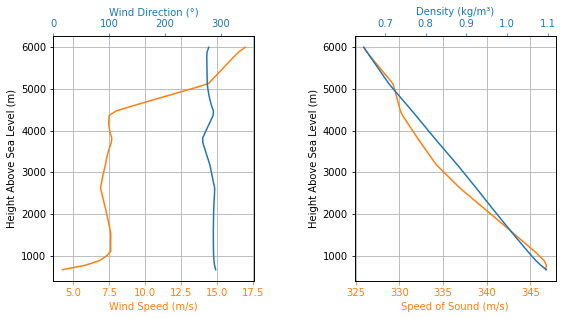

In [12]:
Env = Environment(railLength= 50,            # Comprimento validado
                  gravity=9.8,
                  date=(2020, 11, 29, 12),
                  latitude=-2.31775,             #Lat-lon confirmadas
                  longitude=-44.36802,
                  elevation=668)                 

Env.setAtmosphericModel(type='CostumAtmosphere',
                        pressure='data/weather/Valetudo/valetudo_launch_20190810T210000Z_pressure.csv',
                        temperature='data/weather/Valetudo/valetudo_launch_20190810T210000Z_temperature.csv',
                        wind_u='data/weather/Valetudo/valetudo_launch_20190810T210000Z_wind-u.csv',
                        wind_v='data/weather/Valetudo/valetudo_launch_20190810T210000Z_wind-v.csv')
Env.maxExpectedHeight = 6000

Env.info()

# Motor Data


Motor Details
Total Burning Time: 125.33875338753388 s
Total Propellant Mass: 9248.849 kg
Propellant Exhaust Velocity: 3050.376 m/s
Average Thrust: 225089.757 N
Maximum Thrust: 225000.0 N at 0.0 s after ignition.
Total Impulse: 28212469.512 Ns

Plots


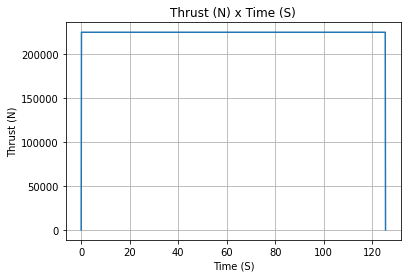

In [13]:
N = 9
Vq = 8.2 * N
Mp = 9250
T = Mp / Vq
#ImpTot = 3050 * Mp

tempo = np.linspace(0, T, 10 * T)
empuxo = [[0,0]]
for i in range(len(tempo)):
    empuxo.append([tempo[i], N * 25000])
empuxo.append([tempo[i]+0.1, 0])
    
MARIMBONDO  = SolidMotor(thrustSource=empuxo,
                          burnOut=T,
                          reshapeThrustCurve= False,
                          grainNumber=1,
                          grainSeparation=0,
                          grainOuterRadius= 0.5,
                          grainInitialInnerRadius=0.3,
                          grainInitialHeight=10,
                          grainDensity= 920*2,               #Considerando a massa de óxido nitroso
                          nozzleRadius=0.5,
                          throatRadius=0.2,
                          interpolationMethod='linear',)


MARIMBONDO.info()

# Find the Pressure at Main parachute deployment height



In [14]:
main_deployment_height_AGL = 530 #m                                
 
main_deployment_height_ASL = main_deployment_height_AGL + Env.elevation   # This is the Main parachute deployment altitude above sea level

p = Env.pressure(main_deployment_height_ASL)    # This is the Pressure at Main parachute deployment height

print('Pressure at', main_deployment_height_AGL, 'm (AGL) =', p, 'Pa =', p/(10**5), 'bar')

Pressure at 530 m (AGL) = 88633.58747628177 Pa = 0.8863358747628177 bar


# Importing the SRAD avionics algorithm for parachute deployment signal

In [15]:
def drogueTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate drogue when vz < 0 m/s.
    return True if y[5] < 0 else False

def mainTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate main when vz < 0 m/s and z < 800 m.
    return True if y[5] < 0 and y[2] < 800 else False


# Rocket Data

In [16]:
#help(Rocket)

Inertia Details
Rocket Mass: 2350.000 kg (No Propellant)
Rocket Mass: 11598.849 kg (With Propellant)
Rocket Inertia I: 48600.000 kg*m2
Rocket Inertia Z: 411.000 kg*m2

Geometrical Parameters
Rocket Maximum Radius: 0.6 m
Rocket Frontal Area: 1.130973 m2

Rocket Distances
Rocket Center of Mass - Nozzle Exit Distance: -8 m
Rocket Center of Mass - Propellant Center of Mass Distance: -1 m
Rocket Center of Mass - Rocket Loaded Center of Mass: -0.797 m

Aerodynamic Coponents Parameters
Currently not implemented.

Aerodynamics Lift Coefficient Derivatives
Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 7.866/rad

Aerodynamics Center of Pressure
Nose Cone Center of Pressure to CM: 12.750 m
Fins Center of Pressure to CM: -7.708 m
Distance - Center of Pressure to CM: -3.561 m
Initial Static Margin: 2.303 c
Final Static Margin: 2.966 c

Mass Plots


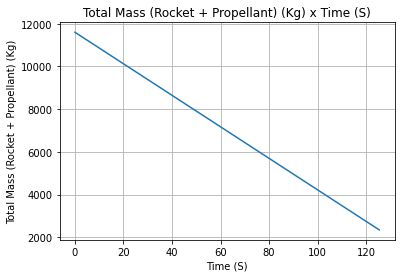

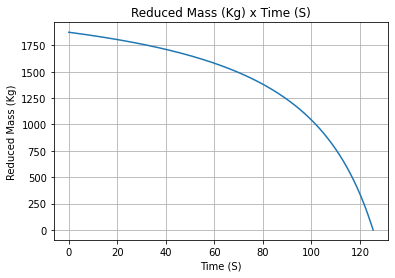


Aerodynamics Plots


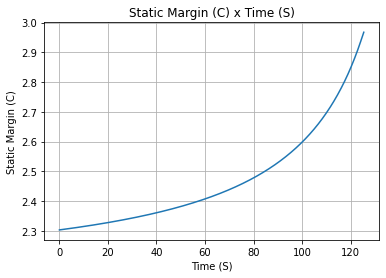

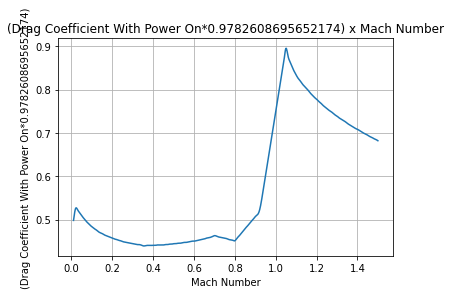

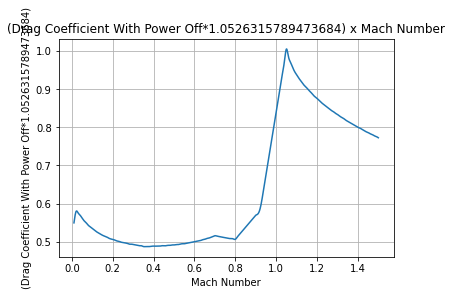

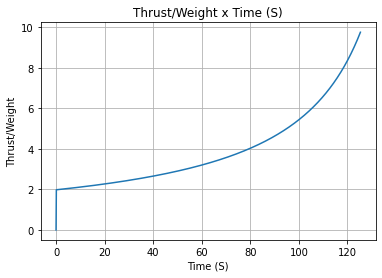

In [17]:
# Próximos valores são relativos a um sistema de coordenadas com origem no bico da ogiva

Posição_CMgraos = 15      # Posição do centro de massa de todos os grãos e espaçadores, em metros 
Posição_aletas  = 21          # Posição das Aletas no CAD, considerar o ponto de encontro da aleta com o corpo do foguete mais próximo da origem
#Posição_cauda   = 3024.29 /1000       # Posição da transição entre o corpo cilíndrico do foguete e a cauda, que em geral é um tronco de cone ou não existe mesmo
Posição_nozzle  = 22       # Posição da saída do Nozzle (bocal). É também a posição da seção de maior diâmetro do nozzle
Posição_CM_descarregado = 14     # Posição do Centro de Massa do foguete sem os grãos de propelente ou espaçadores entre grãos


# A partir de agora nosso sistema de coordenadas passa a ter origem no centro de massa do foguete descarregado

EUROPA = Rocket(motor= MARIMBONDO,
                radius= 0.6,
                mass= 2350,                 # Pegar a massa do foguete no CAD, desconsiderar a massa do propelente
                inertiaI= 48600,          # Não esquecer de pegar no CAD com o Foguete Descarregado
                inertiaZ= 411,           # Não esquecer de pegar no CAD com o Foguete Descarregado
                distanceRocketNozzle= Posição_CM_descarregado - Posição_nozzle,
                distanceRocketPropellant= Posição_CM_descarregado - Posição_CMgraos,
                powerOffDrag='data/europa/Europa_drag_power_off.csv',
                powerOnDrag='data/europa/Europa_drag_power_on.csv')


EUROPA.powerOnDrag *= 0.45/EUROPA.powerOnDrag(0.6)     # Dados obtidos do CFD
EUROPA.powerOffDrag *= 0.5/EUROPA.powerOffDrag(0.6)    # Dados obtidos do CFD

EUROPA.addNose(length=2.5, kind="vonKarman", distanceToCM= abs(Posição_CM_descarregado - 2.5))

EUROPA.addFins(4, span = 1.2, rootChord = 1.5, tipChord = 0.4, distanceToCM= Posição_CM_descarregado - Posição_aletas)# airfoil = 'data/europa/NACA0012_Cl_em_radianos.csv')

#EUROPA.addTail(topRadius=0.064, bottomRadius=0.0461, length=0.060, distanceToCM= Posição_CM_descarregado - Posição_cauda)

EUROPA.setRailButtons([Posição_CM_descarregado - 12, Posição_CM_descarregado - 21], 45)

  
EUROPA.allInfo()

## Enable avionics systems before flight (Remove before flight)

# Finally, the Trajectory Simulation

8.31700769  182941.15965195 6378225.84337856]
6391819.307986638
[-374340.59374735  182947.11192906 6378204.42441247]
6391798.823921568
[-374342.51668655  182948.04429717 6378201.06246262]
6391795.608427308
[-374344.43867903  182948.97621855 6378197.70025752]
6391792.392610989
[-374346.35972509  182949.90769323 6378194.33779755]
6391789.176472974
[-374348.27982501  182950.83872129 6378190.97508305]
6391785.9600136485
[-374350.19897909  182951.76930296 6378187.61211442]
6391782.74323343
[-374352.11718759  182952.69943857 6378184.24889209]
6391779.526132759
[-374354.03445079  182953.62912854 6378180.88541647]
6391776.30871207
[-374357.09991479  182955.11561375 6378175.50366674]
6391771.160496935
[-374359.23460423  182956.1507739  6378171.75309978]
6391767.572563895
[-374360.92153206  182956.9688161  6378168.78755133]
6391764.73554078
[-374362.60772647  182957.78651343 6378165.82180743]
6391761.898270466
[-374364.29318766  182958.60386618 6378162.85586833]
6391759.060753231
[-374366.890469

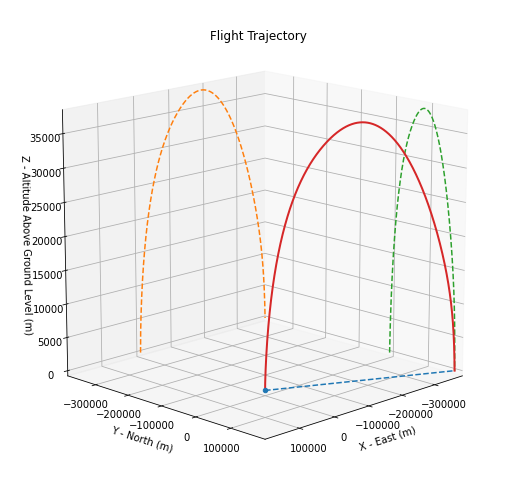



Trajectory Kinematic Plots



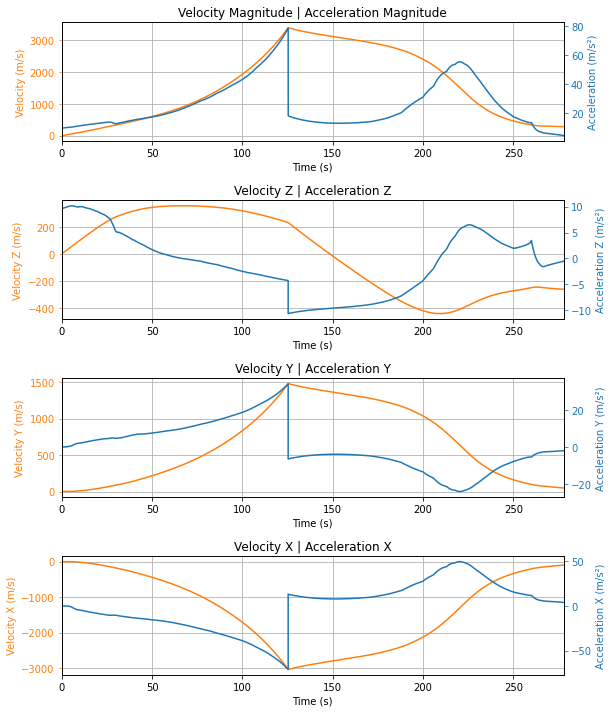



Angular Position Plots



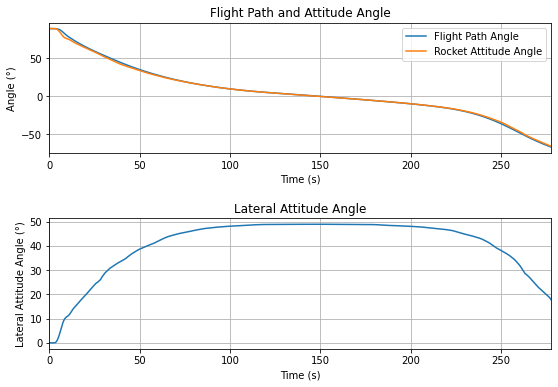



Path, Attitude and Lateral Attitude Angle plots



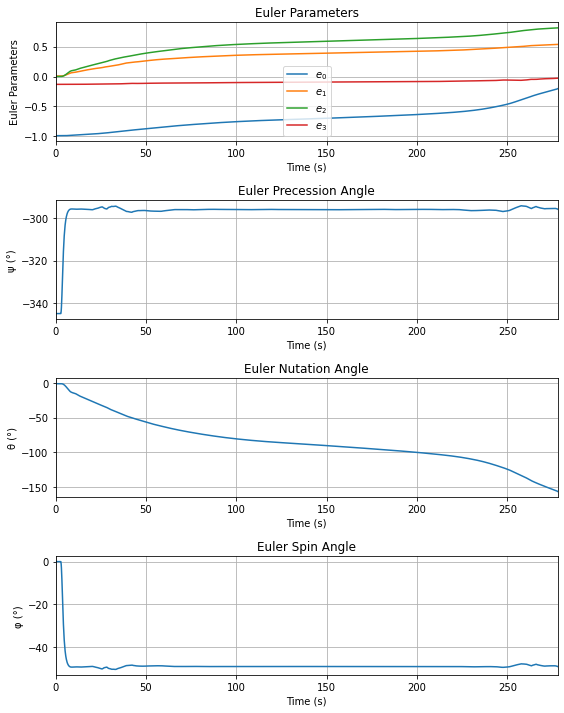



Trajectory Angular Velocity and Acceleration Plots



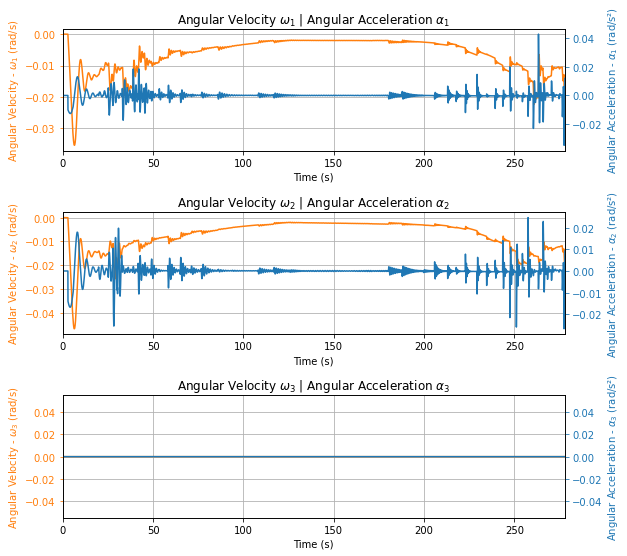



Trajectory Force Plots



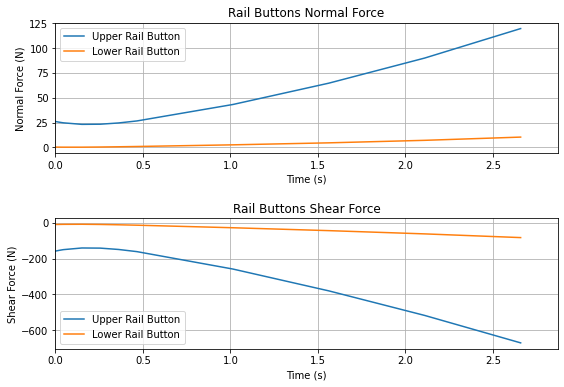

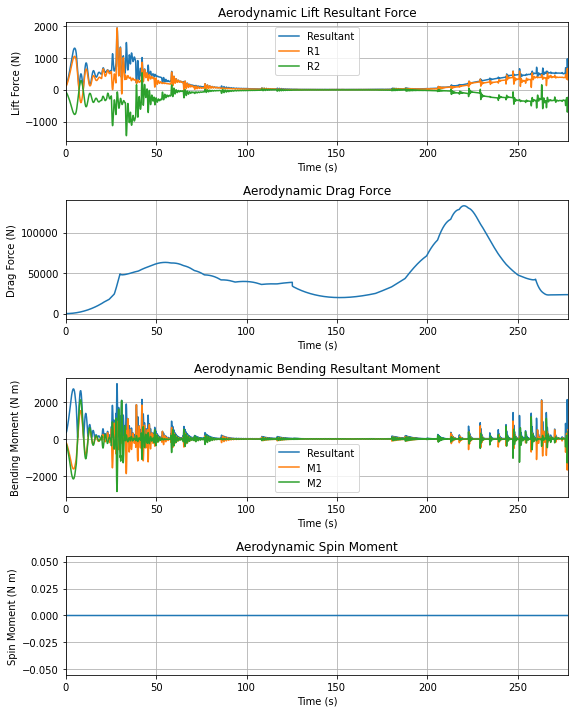



Trajectory Energy Plots



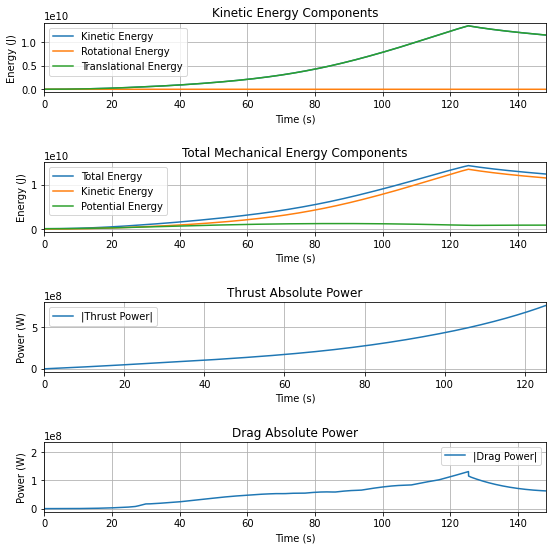



Trajectory Fluid Mechanics Plots



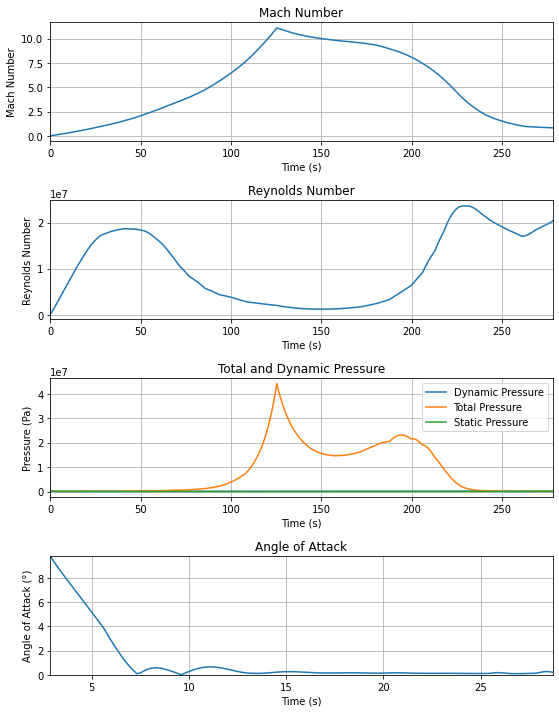



Trajectory Stability and Control Plots



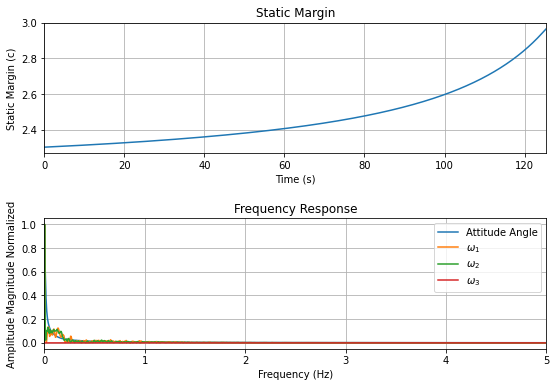

[-374053.0507431   182807.87047681 6378686.68146052]
6392259.239308145
[-374058.98501025  182810.73977693 6378677.12028787]
6392250.127750688
[-374064.91099417  182813.6051648  6378667.55678633]
6392241.013280778
[-374071.64878866  182816.86324313 6378656.66406072]
6392230.631155279
[-374078.37585676  182820.1163471  6378645.76831348]
6392220.245255025
[-374085.09220635  182823.36452381 6378634.86954406]
6392209.855581257
[-374091.79784658  182826.60781393 6378623.96775208]
6392199.462135249
[-374098.49278839  182829.84625041 6378613.06293723]
6392189.064918211
[-374108.27803625  182834.58012677 6378597.08773185]
6392173.8317263145
[-374118.04041631  182839.30369028 6378581.10604187]
6392158.590452305
[-374125.90983299  182843.11187317 6378568.19125794]
6392146.272614187
[-374133.76439914  182846.91332378 6378555.27224215]
6392133.949505722
[-374141.60415048  182850.70802532 6378542.34899526]
6392121.621129219
[-374149.42912372  182854.49595566 6378529.42151895]
6392109.28748779
[-3741

In [18]:
TestFlight = Flight(rocket=EUROPA, environment=Env, inclination=89, heading=345, rtol=1e-6, atol=1e-6, maxTime = 1000, orbitalFlight=True)
TestFlight.allInfo()
TestFlight.postProcess()
#TestFlight.info()


In [19]:
import numpy as np

espessura = 1.2 * 4 / 100
N = 7
dInternoFoguete = 1.2 - espessura
dInternoGrao = 0
densidadeGrao = 920 
densidadeLinearFuselagem = 78.52
m2Estagio = 2350
mdot = 8.2 * N
IPS = 3050
raioDoNozzle = 0.5
raioGargantaNozzle = 0.3
inerciaGrande = 48600
inerciaPequena = 411
Logiva = 2.5
CDOff = 0.5
CDOn = 0.45
coefVolume = 0.8

In [20]:
def calibra(h0, m, de):
    rho = 100
    for i in range(1000000000):
        h = m * 4 / (coefVolume * np.pi * (de**2) * rho)
        #print(abs(h-h0))
        if abs(h-h0) < 0.001:
            return rho
        else: rho+=0.1
calibra(12.1, 9250, dInternoFoguete)

916.8000000001414

In [21]:
print(1.2 * 4)

4.8


h =  6.517744779638816
Massa Unloaded =  2861.77332009724
Massa Propelente = 5000.0
-------------------------------------
h =  7.821293735566579
Massa Unloaded =  2964.127984116688
Massa Propelente = 6000.000000000001
-------------------------------------
h =  9.124842691494342
Massa Unloaded =  3066.4826481361356
Massa Propelente = 7000.0
-------------------------------------
h =  10.428391647422105
Massa Unloaded =  3168.8373121555837
Massa Propelente = 8000.0
-------------------------------------
h =  11.73194060334987
Massa Unloaded =  3271.191976175032
Massa Propelente = 9000.000000000002
-------------------------------------
h =  13.035489559277632
Massa Unloaded =  3373.5466401944796
Massa Propelente = 10000.0
-------------------------------------


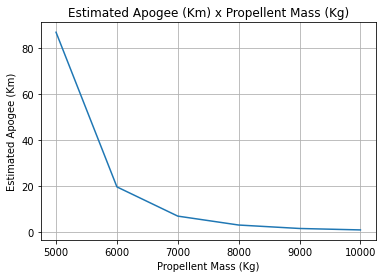

In [29]:
def superapogee(mass):
    massaPropelente = mass

    Posição_CMgraos = 15      # Posição do centro de massa de todos os grãos e espaçadores, em metros 
    Posição_aletas  = 21          # Posição das Aletas no CAD, considerar o ponto de encontro da aleta com o corpo do foguete mais próximo 
    Posição_nozzle  = 22       # Posição da saída do Nozzle (bocal). É também a posição da seção de maior diâmetro do nozzle
    Posição_CM_descarregado = 14     # Posição do Centro de Massa do foguete sem os grãos de propelente ou espaçadores entre grãos
    
    
    T = massaPropelente / mdot
    #ImpTot = IPS * massaPropelente
    h = massaPropelente * 4 / (coefVolume * np.pi * (dInternoFoguete**2 - dInternoGrao**2) * densidadeGrao)
    #folgaNaFuselagem = h * (1 - coefVolume)

    tempo = np.linspace(0, T, 10 * T)
    empuxo = [[0,0]]
    for i in range(len(tempo)):
        empuxo.append([tempo[i], N * 25000])
    empuxo.append([tempo[i]+0.1, 0])
    
    print('h = ', h)
    # print("Impulso Total =", ImpTot)

    massa_unloaded = densidadeLinearFuselagem * h + m2Estagio
    print('Massa Unloaded = ', massa_unloaded)
    #massa_total_cad = massa_unloaded + mass
    
    MARIMBONDO  = SolidMotor(thrustSource=empuxo,
                            burnOut=T,
                            reshapeThrustCurve= False,
                            grainNumber=1,
                            grainSeparation=0,
                            grainOuterRadius= dInternoFoguete / 2,
                            grainInitialInnerRadius= dInternoGrao / 2,
                            grainInitialHeight= h * coefVolume,
                            grainDensity= densidadeGrao,               #Considerando a massa de óxido nitroso
                            nozzleRadius=0.5,
                            throatRadius=0.2,
                            interpolationMethod='linear',)
    # MARIMBONDO.info()
    print('Massa Propelente =', MARIMBONDO.mass(0))
    
    

    
    R = Rocket(motor= MARIMBONDO,
                    radius= 0.6,
                    mass= massa_unloaded,                 # Pegar a massa do foguete no CAD, desconsiderar a massa do propelente
                    inertiaI= inerciaGrande,          # Não esquecer de pegar no CAD com o Foguete Descarregado
                    inertiaZ= inerciaPequena,           # Não esquecer de pegar no CAD com o Foguete Descarregado
                    distanceRocketNozzle= Posição_CM_descarregado - Posição_nozzle,
                    distanceRocketPropellant= Posição_CM_descarregado - Posição_CMgraos,
                    powerOffDrag='data/europa/Europa_drag_power_off.csv',
                    powerOnDrag='data/europa/Europa_drag_power_on.csv')


    R.powerOnDrag *= CDOn/EUROPA.powerOnDrag(0.6)     # Dados obtidos do CFD
    R.powerOffDrag *= CDOff/EUROPA.powerOffDrag(0.6)    # Dados obtidos do CFD

    R.addNose(length=Logiva, kind="vonKarman", distanceToCM= abs(Posição_CM_descarregado - Logiva))

    R.addFins(4, span = 1.2, rootChord = 1.5, tipChord = 0.4, distanceToCM= Posição_CM_descarregado - Posição_aletas)

    R.setRailButtons([Posição_CM_descarregado - 12, Posição_CM_descarregado - 21], 45)
    
    #R.info()
    
    TF = TestFlight = Flight(rocket=R, environment=Env, inclination=89, heading=345, rtol=1e-6, atol=1e-6, maxTime = 10000, orbitalFlight=True)
    #TF.allInfo()
    #TF.info()
    
    TF.postProcess()
    #TF.z()
    print('-------------------------------------')
    return (TF.apogee - Env.elevation)/1000
  
superapogeebymass = Function(superapogee, inputs="Propellent Mass (kg)", outputs="Estimated Apogee (km)")
superapogeebymass.plot(5000, 10000, 6)

h =  6.517744779638816
Massa Unloaded =  2861.77332009724
Massa Propelente = 5000.0
Vx =  1455.963120578304
Vy =  332.15500803325415
Vz =  -1.4111165671576095e-06
Speed =  1493.3705360176793
Raio =  6408.62086850665 km
Apogeu =  33.62086850665044 km
Velocidade Orbital =  7886.432413949778 m/s
Delta Velocidade Orbital =  6393.0618779320985 m/s
-------------------------------------
h =  7.821293735566579
Massa Unloaded =  2964.127984116688
Massa Propelente = 6000.000000000001
Vx =  851.3301989617888
Vy =  194.67159288955494
Vz =  0.0005777007206084761
Speed =  873.3041490285291
Raio =  6385.193718745406 km
Apogeu =  10.193718745405786 km
Velocidade Orbital =  7900.886750375458 m/s
Delta Velocidade Orbital =  7027.582601346929 m/s
-------------------------------------
h =  9.124842691494342
Massa Unloaded =  3066.4826481361356
Massa Propelente = 7000.0
Vx =  538.0708520384276
Vy =  117.51994102239381
Vz =  0.0032450121187230785
Speed =  550.7550983710122
Raio =  6379.763737154225 km
Apoge

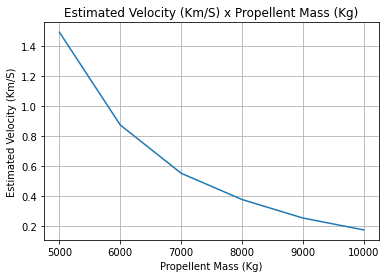

In [47]:
def supervelocity(mass):
    massaPropelente = mass

    Posição_CMgraos = 15      # Posição do centro de massa de todos os grãos e espaçadores, em metros 
    Posição_aletas  = 21          # Posição das Aletas no CAD, considerar o ponto de encontro da aleta com o corpo do foguete mais próximo 
    Posição_nozzle  = 22       # Posição da saída do Nozzle (bocal). É também a posição da seção de maior diâmetro do nozzle
    Posição_CM_descarregado = 14     # Posição do Centro de Massa do foguete sem os grãos de propelente ou espaçadores entre grãos
    
    
    T = massaPropelente / mdot
    #ImpTot = IPS * massaPropelente
    h = massaPropelente * 4 / (coefVolume * np.pi * (dInternoFoguete**2 - dInternoGrao**2) * densidadeGrao)
    #folgaNaFuselagem = h * (1 - coefVolume)

    tempo = np.linspace(0, T, 10 * T)
    empuxo = [[0,0]]
    for i in range(len(tempo)):
        empuxo.append([tempo[i], N * 25000])
    empuxo.append([tempo[i]+0.1, 0])
    
    print('h = ', h)
    # print("Impulso Total =", ImpTot)

    massa_unloaded = densidadeLinearFuselagem * h + m2Estagio
    print('Massa Unloaded = ', massa_unloaded)
    #massa_total_cad = massa_unloaded + mass
    
    MARIMBONDO  = SolidMotor(thrustSource=empuxo,
                            burnOut=T,
                            reshapeThrustCurve= False,
                            grainNumber=1,
                            grainSeparation=0,
                            grainOuterRadius= dInternoFoguete / 2,
                            grainInitialInnerRadius= dInternoGrao / 2,
                            grainInitialHeight= h * coefVolume,
                            grainDensity= densidadeGrao,               #Considerando a massa de óxido nitroso
                            nozzleRadius=0.5,
                            throatRadius=0.2,
                            interpolationMethod='linear',)
    # MARIMBONDO.info()
    print('Massa Propelente =', MARIMBONDO.mass(0))
    
    

    
    R = Rocket(motor= MARIMBONDO,
                    radius= 0.6,
                    mass= massa_unloaded,                 # Pegar a massa do foguete no CAD, desconsiderar a massa do propelente
                    inertiaI= inerciaGrande,          # Não esquecer de pegar no CAD com o Foguete Descarregado
                    inertiaZ= inerciaPequena,           # Não esquecer de pegar no CAD com o Foguete Descarregado
                    distanceRocketNozzle= Posição_CM_descarregado - Posição_nozzle,
                    distanceRocketPropellant= Posição_CM_descarregado - Posição_CMgraos,
                    powerOffDrag='data/europa/Europa_drag_power_off.csv',
                    powerOnDrag='data/europa/Europa_drag_power_on.csv')


    R.powerOnDrag *= CDOn/EUROPA.powerOnDrag(0.6)     # Dados obtidos do CFD
    R.powerOffDrag *= CDOff/EUROPA.powerOffDrag(0.6)    # Dados obtidos do CFD

    R.addNose(length=Logiva, kind="vonKarman", distanceToCM= abs(Posição_CM_descarregado - Logiva))

    R.addFins(4, span = 1.2, rootChord = 1.5, tipChord = 0.4, distanceToCM= Posição_CM_descarregado - Posição_aletas)

    R.setRailButtons([Posição_CM_descarregado - 12, Posição_CM_descarregado - 21], 45)

    Voo = Flight(rocket=R, environment=Env, inclination=75)
    Voo.postProcess()
    
    print("Vx = ",Voo.vx(Voo.apogeeTime))
    print("Vy = ", Voo.vy(Voo.apogeeTime))
    print("Vz = ", Voo.vz(Voo.apogeeTime))
    
    print("Speed = ", Voo.speed(Voo.apogeeTime))
    #print("Apogeu = ", TF.z(TF.apogeeTime))
    


    vRaio = np.array([Voo.x(Voo.apogeeTime), Voo.y(Voo.apogeeTime), Voo.z(Voo.apogeeTime) + 6375000])
    raio = np.linalg.norm(vRaio)
    VOrb = np.sqrt(6.67408e-11 * Voo.env.earthMass / raio)

    print("Raio = ", raio/1000, "km")
    print("Apogeu = ", (raio - 6375000)/1000, "km")
    print("Velocidade Orbital = ", VOrb, "m/s")
    print("Delta Velocidade Orbital = ", VOrb - Voo.speed(Voo.apogeeTime), "m/s")
    print('-------------------------------------')
    return np.sqrt(Voo.vy(Voo.apogeeTime)**2 + Voo.vx(Voo.apogeeTime)**2)/1000
  
supervelocitymass = Function(supervelocity, inputs="Propellent Mass (kg)", outputs="Estimated Velocity (km/s)")
supervelocitymass.plot(5000, 10000, 6)

In [ ]:
simulation_results = []
for nMot in range(6, 15):
    N = nMot
    mdot = 8.2 * N
    print("n =", nMot)
    superapogeebymass.plot(5000, 10000, 6)

In [7]:
T = 2150 / mdot
#ImpTot = IPS * massaPropelente
h = 2150 * 4 / (coefVolume * np.pi * (dInternoFoguete**2 - dInternoGrao**2) * densidadeGrao)
print(h)

2.802630255244691


# Fin optmization

In [ ]:
FOGUETON = Rocket(motor= MARIMBONDO,
                radius= 127/2000,
                mass= 24.5,                 # Pegar a massa do foguete no CAD, desconsiderar a massa do propelente
                inertiaI= 16.17,          # Não esquecer de pegar no CAD com o Foguete Descarregado
                inertiaZ= 0.077,           # Não esquecer de pegar no CAD com o Foguete Descarregado
                distanceRocketNozzle= Posição_CM_descarregado - Posição_nozzle,
                distanceRocketPropellant= Posição_CM_descarregado - Posição_CMgraos,
                powerOffDrag='data/europa/Mach x CD - Página1 - Mach x CD - Página1.csv',
                powerOnDrag='data/europa/Mach x CD - Página1 - Mach x CD - Página1.csv')

FOGUETON.addNose(length=558.29/1000, kind="vonKarman", distanceToCM= abs(Posição_CM_descarregado - 558.29/1000))

import numpy as np

n = 3          #n de aletas
spanMin = 0.05
rootMin = 0.05
tipMin = 0.02
spanMax = 0.120
rootMax = 0.15
tipMax = 0.08
distanceToCM = Posição_CM_descarregado - Posição_aletas
paces=0.003
desiredStaticMargin=2

def MeritFunction(staticMargin, desiredStaticMargin, areaFins):
  sigma = 0.2
  return (np.exp(-1*(((staticMargin - desiredStaticMargin)/(2*sigma))**2)))/areaFins

# Stabilishing basic parameters
span = spanMin
root = rootMin
tip = tipMin
highestMerit = 0

while span <= spanMax:
  while root <= rootMax:
    while tip <= tipMax:
      FOGUETON.addFins(n, span, root, tip, distanceToCM)
      staticMargin = FOGUETON.staticMargin(0)
      afterBurnStaticMargin  = FOGUETON.staticMargin(10)
      areaFins = (root + tip) * (span / 2)
      merit = MeritFunction(staticMargin, desiredStaticMargin, areaFins)

      # Saves best Merit value
      if merit > highestMerit:
        highestMerit = merit
        highestMargin = staticMargin
        highestAfterBurnMargin = afterBurnStaticMargin
        spanFinal = span
        rootFinal = root
        tipFinal = tip

      # Removes added fins from rocket
      FOGUETON.aerodynamicSurfaces.pop(-1)

      tip += paces

    root += paces
    tip = tipMin

  span += paces
  root = rootMin
        
print("span: %.3f  root: %.3f  tip: %.3f"%(spanFinal,rootFinal,tipFinal))
print("Merit: %f  |  Margin: %f  |  After Burn Margin: %f"%(highestMerit,highestMargin,highestAfterBurnMargin))

# Plot a "Apogee x Rocket Mass" chart





In [ ]:
def apogee(mass):
  massa_total_cad = mass
  massa_propelente = 5.345
  massa_unloaded = mass - massa_propelente
  
  Posição_CM_graos = 2660.8 /1000       # Posição do centro de massa de todos os grãos e espaçadores, em metros 
  Posição_aletas  = (3209.7 - 16) /1000          # Posição das Aletas no CAD, considerar o ponto de encontro da aleta com o corpo do foguete mais próximo da origem
  Posição_nozzle  = 3425.79 /1000
  Posição_CM_descarregado = 2216 /1000
  
  
  R = Rocket(motor= MARIMBONDO,
                radius= 127/2000,
                mass= massa_unloaded,
                inertiaI=16.17,
                inertiaZ=0.077,
                distanceRocketNozzle= -abs(Posição_CM_descarregado - Posição_nozzle),
                distanceRocketPropellant= -abs(Posição_CM_descarregado - Posição_CM_graos),
                powerOffDrag=EUROPA.powerOffDrag,
                powerOnDrag=EUROPA.powerOffDrag)

  R.addNose(length=558.29/1000, kind="vonKarman", distanceToCM= abs(Posição_CM_descarregado - 558.29/1000))

  R.addFins(4, span = 0.09, rootChord = 0.1, tipChord = 0.020, distanceToCM= Posição_CM_descarregado - Posição_aletas)

  R.setRailButtons([Posição_CM_descarregado - 2.086, Posição_CM_descarregado - 3.397], 45)
      
  TF = Flight(rocket=R, environment=Env, inclination=85, terminateOnApogee=True, heading=45)
  
  return TF.apogee - Env.elevation
  
apogeebymass = Function(apogee, inputs="Mass (kg)", outputs="Estimated Apogee (m)")
apogeebymass.plot(20,35,30)

# Plot a "Out of Rail Velocity x Rocket Mass" chart

In [ ]:
def vel(mass):
  massa_total_cad = mass
  massa_propelente = 5.345
  massa_unloaded = mass - massa_propelente
  
  Posição_CM_graos = 2660.8 /1000       # Posição do centro de massa de todos os grãos e espaçadores, em metros 
  Posição_aletas  = (3209.7 - 16) /1000          # Posição das Aletas no CAD, considerar o ponto de encontro da aleta com o corpo do foguete mais próximo da origem
  Posição_nozzle  = 3425.79 /1000
  Posição_CM_descarregado = 2216 /1000
  
  
  R = Rocket(motor= MARIMBONDO,
                radius= 127/2000,
                mass= massa_unloaded,
                inertiaI=16.17,
                inertiaZ=0.077,
                distanceRocketNozzle= -abs(Posição_CM_descarregado - Posição_nozzle),
                distanceRocketPropellant= -abs(Posição_CM_descarregado - Posição_CM_graos),
                powerOffDrag=EUROPA.powerOffDrag,
                powerOnDrag=EUROPA.powerOffDrag)

  R.addNose(length=558.29/1000, kind="vonKarman", distanceToCM= abs(Posição_CM_descarregado - 558.29/1000))

  R.addFins(4, span = 0.09, rootChord = 0.1, tipChord = 0.020, distanceToCM= Posição_CM_descarregado - Posição_aletas)

  R.setRailButtons([Posição_CM_descarregado - 2.086, Posição_CM_descarregado - 3.397], 45)
      
  TF = Flight(rocket=R, environment=Env, inclination=85, terminateOnApogee=True, heading=45)
  return TF.outOfRailVelocity

velbymass = Function(vel, inputs="Mass (kg) - with propellant", outputs="Estimated Out Of Rail Velocity (m/s)")
velbymass.plot(20,35, 30)

In [ ]:
def flight(delta_fin):
  massa_unloaded = 24.5
  massa_propelente = 5.345
  massa_total_cad = massa_unloaded + massa_propelente
  
  Posição_CM_graos = 2660.8 /1000       # Posição do centro de massa de todos os grãos e espaçadores, em metros 
  Posição_aletas  = (3209.7 - 16) /1000          # Posição das Aletas no CAD, considerar o ponto de encontro da aleta com o corpo do foguete mais próximo da origem
  Posição_nozzle  = 3425.79 /1000
  Posição_CM_descarregado = 2216 /1000
  
  
  R = Rocket(motor= MARIMBONDO,
                radius= 127/2000,
                mass= massa_unloaded,
                inertiaI=16.17,
                inertiaZ=0.077,
                distanceRocketNozzle= -abs(Posição_CM_descarregado - Posição_nozzle),
                distanceRocketPropellant= -abs(Posição_CM_descarregado - Posição_CM_graos),
                powerOffDrag=EUROPA.powerOffDrag,
                powerOnDrag=EUROPA.powerOffDrag)

  R.addNose(length=558.29/1000, kind="vonKarman", distanceToCM= abs(Posição_CM_descarregado - 558.29/1000))

  R.addFins(4, span = 0.09, rootChord = 0.1, tipChord = 0.020, distanceToCM= Posição_CM_descarregado - Posição_aletas, delta=delta_fin)

  R.setRailButtons([Posição_CM_descarregado - 2.086, Posição_CM_descarregado - 3.397], 45)
      
  TF = Flight(rocket=R, environment=Env, inclination=85, terminateOnApogee=True, heading=45)
  TF.postProcess()
  return TF.w3 

def omega(min, max, step):
    #simulation_results = [(TestFlight.speed, 'Velocity magnitute')]
    simulation_results = []
    for delta in range(min, max+1, step):
        #simulation_results.append(flight(delta))
        simulation_results += [(flight(delta), 'Delta =' + '{:1.2f}'.format(delta))]
    Function.comparePlots(simulation_results,lower=0, upper=26, xlabel='Time (s)', ylabel='Angular Speed (rad/s) and Velocity (m/s)')

omega(1,3,1)

# Saving all results as .html

In [ ]:
!jupyter nbconvert --output-dir='/gdrive/Shared drives/O Projeto Jupiter/Aerodinâmica/RocketPy/Reports/Europa/LASC 2020/' --to html "Europa Hibrido Flight Simulation.ipynb" --output "Europa_Hibrido_Flight_Simulation_Oct_16.ipynb"